# Results of 3xM Investigation
Compare results and create visualization

- [Imports](#imports)
- [Bias Experiment](#bias-experiment)
- [In-Distribution Experiment](#in-distribution-experiment)
- [Sim-To-Real Experiment](#sim-to-real-experiment)



**Statistical Significants:**

The hypothesis test checks if the difference from 2 results are statistical significant or also can be just randomness.

The Wilcoxon hypothesis test is applied due to the not normal distributed data and most likely small amount of data.

Understanding p-values in the Context of Statistical Significance:
- Each cell in the heatmap represents the p-value from a pairwise statistical test comparing the Intersection over Union (IOU) results of two experiments.
- A **p-value** indicates the probability that the observed difference between two sets of IOU results is due to random chance. Lower p-values (< 5%) suggest a significant difference, while higher p-values (>= 5%) suggest that the difference may not be meaningful.


---
### Imports

In [159]:
import os
import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import numpy as np
import scipy.stats as stats

---
### Bias Experiment

In [160]:
# manual writing of every object
bias_results = {
    "rgb 10 10": {
            "multiple textures": {"texture":8, "shape":1},
            "one texture":       {"texture":7, "shape":8}
    },
    "rgb 10 80": {
            "multiple textures": {"texture":7, "shape":2},
            "one texture":       {"texture":8, "shape":7}
    },
    "rgb 10 160": {
            "multiple textures": {"texture":7, "shape":2},
            "one texture":       {"texture":9, "shape":6}
    },
    "rgb 80 10": {
            "multiple textures": {"texture":8, "shape":1},
            "one texture":       {"texture":8, "shape":7}
    },
    "rgb 80 80": {
            "multiple textures": {"texture":7, "shape":2},
            "one texture":       {"texture":9, "shape":6}
    },
    "rgb 80 160": {
            "multiple textures": {"texture":8, "shape":1},
            "one texture":       {"texture":8, "shape":7}
    },
    "rgb 160 10": {
            "multiple textures": {"texture":8, "shape":1},
            "one texture":       {"texture":7, "shape":8}
    },
    "rgb 160 80": {
            "multiple textures": {"texture":8, "shape":1},
            "one texture":       {"texture":8, "shape":7}
    },
    "rgb 160 160": {
            "multiple textures": {"texture":8, "shape":1},
            "one texture":       {"texture":7, "shape":8}
    },
    "rgbd 10 10": {
            "multiple textures": {"texture":6, "shape":2},
            "one texture":       {"texture":2, "shape":13}
    },
    "rgbd 10 80": {
            "multiple textures": {"texture":3, "shape":6},
            "one texture":       {"texture":4, "shape":11}
    },
    "rgbd 10 160": {
            "multiple textures": {"texture":5, "shape":4},
            "one texture":       {"texture":8, "shape":7}
    },
    "rgbd 80 10": {
            "multiple textures": {"texture":7, "shape":2},
            "one texture":       {"texture":6, "shape":9}
    },
    "rgbd 80 80": {
            "multiple textures": {"texture":7, "shape":2},
            "one texture":       {"texture":8, "shape":7}
    },
    "rgbd 80 160": {
            "multiple textures": {"texture":7, "shape":2},
            "one texture":       {"texture":8, "shape":7}
    },
    "rgbd 160 10": {
            "multiple textures": {"texture":7, "shape":2},
            "one texture":       {"texture":9, "shape":6}
    },
    "rgbd 160 80": {
            "multiple textures": {"texture":7, "shape":2},
            "one texture":       {"texture":4, "shape":11}
    },
    "rgbd 160 160": {
            "multiple textures": {"texture":7, "shape":2},
            "one texture":       {"texture":8, "shape":7}
    },
}

In [161]:
total = {}

for model_name, categories in bias_results.items():
    texture = 0
    shape = 0
    for category_name, values in categories.items():
        texture += values["texture"]
        shape += values["shape"]

    total[model_name] = {"texture": texture, "shape": shape}

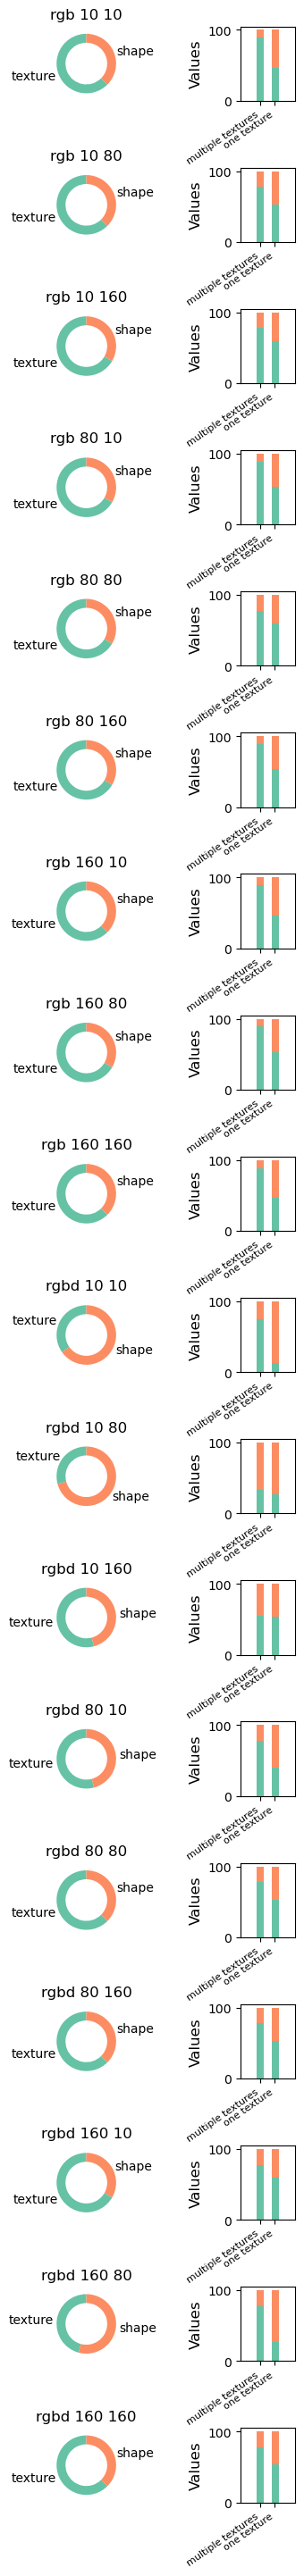

In [162]:
# create donut charts
fig, ax = plt.subplots(len(total.keys()), 2, figsize=(5, 2*len(total.keys())), subplot_kw={'aspect': 'equal'})

colors = ['#66c2a5', '#fc8d62']

for idx, (model_name, data) in enumerate(total.items()):
    values = list(data.values()) 
    labels = list(data.keys())

    # bake donut
    ax[idx][0].pie(
        values,
        labels=labels,
        #autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        wedgeprops={'width': 0.3},  # change from circle to donut
        pctdistance=0.85
    )
    
    ax[idx][0].set_title(model_name, fontsize=12)

    # make bar plot
    categories = list(bias_results[model_name].keys())  # "known-known", "known-unknown", ...
    texture_values = [bias_results[model_name][cat]["texture"]/(bias_results[model_name][cat]["texture"]+bias_results[model_name][cat]["shape"]) for cat in categories]
    shape_values = [bias_results[model_name][cat]["shape"]/(bias_results[model_name][cat]["texture"]+bias_results[model_name][cat]["shape"]) for cat in categories]

    # Breite der Balken
    bar_width = 10
    x = np.arange(len(categories))  # Positionen der Kategorien

    # add spacing
    new_x = []
    new_textures = []
    new_shapes = []
    x_counter = 0
    
    cur_idx = -0.5
    while cur_idx < len(texture_values):
        if cur_idx % 1 != 0.0:
            for _ in range(20):
                new_x += [x_counter]
                x_counter += 1
            new_textures += [0]*20
            new_shapes += [0]*20
        else:
            new_x += [x_counter]
            x_counter += 1
            new_textures += [texture_values[int(cur_idx)]*100]
            new_shapes += [shape_values[int(cur_idx)]*100]
        cur_idx += 0.5

    x = new_x
    texture_values = new_textures
    shape_values = new_shapes

    # create stacked bar chart
    ax[idx][1].bar(x, texture_values, width=bar_width, label="Texture", color=colors[0])
    ax[idx][1].bar(x, shape_values, width=bar_width, bottom=texture_values, label="Shape", color=colors[1])

    # title and labels
    # ax[idx][1].set_xlabel("Categories", fontsize=12)
    ax[idx][1].set_ylabel("Values", fontsize=12)
    # ax[idx][1].set_title("Stacked Texture and Shape Counts per Category", fontsize=14)
    ax[idx][1].set_xticks(np.array([20, 20*2]))
    ax[idx][1].set_xticklabels(categories, rotation=35, ha="right", fontsize=8)

    # add legend
    # ax[idx][1].legend()

# Distance between the charts
plt.subplots_adjust(wspace=0.1, hspace=0.9)
# fig.suptitle("Texture vs Shape Bias on Confusing Data", fontsize=16)
plt.show()

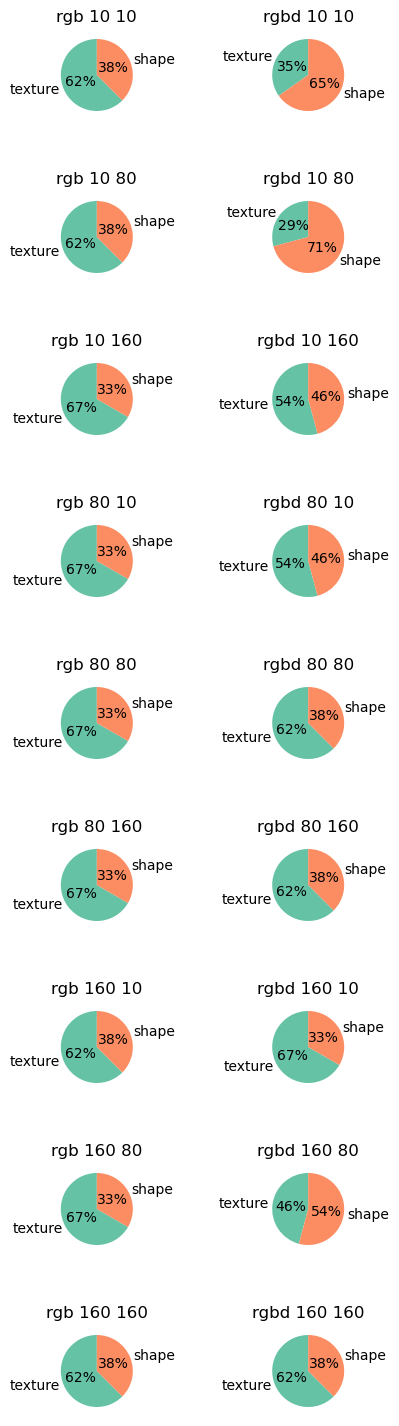

In [163]:
# create donut charts
rows = len(total.keys())//2
cols = 2
fig, ax = plt.subplots(rows, cols, figsize=(5, len(total.keys())), subplot_kw={'aspect': 'equal'})

colors = ['#66c2a5', '#fc8d62']

row = -1
col = 0

for idx, (model_name, data) in enumerate(total.items()):
    values = list(data.values()) 
    labels = list(data.keys())

    # col = idx%2
    # row = idx//2
    if row >= rows-1:
        row = 0
        col += 1
    else:
        row += 1

    # bake donut
    ax[row][col].pie(
        values,
        labels=labels,
        autopct='%1.0f%%',
        startangle=90,
        colors=colors,
        # wedgeprops={'width': 0.35},  # change from circle to donut
        pctdistance=0.5
    )
    
    ax[row][col].set_title(model_name, fontsize=12)

    # make bar plot
    categories = list(bias_results[model_name].keys())  # "known-known", "known-unknown", ...
    texture_values = [bias_results[model_name][cat]["texture"] for cat in categories]
    shape_values = [bias_results[model_name][cat]["shape"] for cat in categories]

# Distance between the charts
plt.subplots_adjust(hspace=0.8)
# fig.suptitle("Texture vs Shape Bias on Confusing Data", fontsize=14)
plt.show()

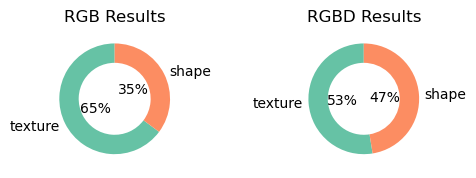

In [164]:
# create donut charts
fig, ax = plt.subplots(1, 2, figsize=(5, 4), subplot_kw={'aspect': 'equal'})

colors = ['#66c2a5', '#fc8d62']

avg_rgbd = {}
avg_rgb = {}

for idx, (model_name, data) in enumerate(bias_results.items()):
    values = list(data.values()) 
    labels = list(data.keys())

    if "rgbd" in model_name:
        if "shape" in avg_rgbd.keys():
            avg_rgbd["shape"] += values[0]["shape"] + values[1]["shape"]
            avg_rgbd["texture"] += values[0]["texture"] + values[1]["texture"] 
        else:
            avg_rgbd["shape"] = values[0]["shape"] + values[1]["shape"]
            avg_rgbd["texture"] = values[0]["texture"] + values[1]["texture"]
    else:
        if "shape" in avg_rgb.keys():
            avg_rgb["shape"] += values[0]["shape"] + values[1]["shape"]
            avg_rgb["texture"] += values[0]["texture"] + values[1]["texture"] 
        else:
            avg_rgb["shape"] = values[0]["shape"] + values[1]["shape"]
            avg_rgb["texture"] = values[0]["texture"] + values[1]["texture"]


# bake donut
ax[0].pie(
    [avg_rgb["texture"], avg_rgb["shape"]],
    labels=["texture", "shape"],
    autopct='%1.0f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'width': 0.35},  # change from circle to donut
    pctdistance=0.38
)
ax[0].set_title("RGB Results", fontsize=12)

ax[1].pie(
    [avg_rgbd["texture"], avg_rgbd["shape"]],
    labels=["texture", "shape"],
    autopct='%1.0f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'width': 0.35},  # change from circle to donut
    pctdistance=0.38
)
ax[1].set_title("RGBD Results", fontsize=12)

# Distance between the charts
plt.subplots_adjust(wspace=0.8)
# fig.suptitle("Texture vs Shape Bias on Confusing Data", fontsize=14)
plt.show()

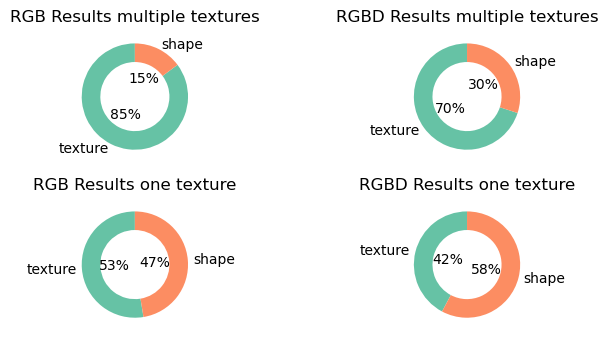

In [165]:
# create donut charts
fig, ax = plt.subplots(2, 2, figsize=(6, 4), subplot_kw={'aspect': 'equal'})

colors = ['#66c2a5', '#fc8d62']

avg_rgbd = {}
avg_rgb = {}

for idx, (model_name, data) in enumerate(bias_results.items()):
    values = list(data.values()) 
    labels = list(data.keys())

    if "rgbd" in model_name:
        if labels[0] in avg_rgbd.keys():
            avg_rgbd[labels[0]]["shape"] += values[0]["shape"] 
            avg_rgbd[labels[0]]["texture"] += values[0]["texture"]
            avg_rgbd[labels[1]]["shape"] += values[1]["shape"] 
            avg_rgbd[labels[1]]["texture"] += values[1]["texture"]
        else:
            avg_rgbd[labels[0]] = dict()
            avg_rgbd[labels[0]]["shape"] = values[0]["shape"] 
            avg_rgbd[labels[0]]["texture"] = values[0]["texture"]
            avg_rgbd[labels[1]] = dict()
            avg_rgbd[labels[1]]["shape"] = values[1]["shape"] 
            avg_rgbd[labels[1]]["texture"] = values[1]["texture"]
    else:
        if labels[0] in avg_rgb.keys():
            avg_rgb[labels[0]]["shape"] += values[0]["shape"] 
            avg_rgb[labels[0]]["texture"] += values[0]["texture"]
            avg_rgb[labels[1]]["shape"] += values[1]["shape"] 
            avg_rgb[labels[1]]["texture"] += values[1]["texture"]
        else:
            avg_rgb[labels[0]] = dict()
            avg_rgb[labels[0]]["shape"] = values[0]["shape"] 
            avg_rgb[labels[0]]["texture"] = values[0]["texture"]
            avg_rgb[labels[1]] = dict()
            avg_rgb[labels[1]]["shape"] = values[1]["shape"] 
            avg_rgb[labels[1]]["texture"] = values[1]["texture"]


# bake donut
ax[0][0].pie(
    [avg_rgb[labels[0]]["texture"], avg_rgb[labels[0]]["shape"]],
    labels=["texture", "shape"],
    autopct='%1.0f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'width': 0.35},  # change from circle to donut
    pctdistance=0.38
)
ax[0][0].set_title(f"RGB Results {labels[0]}", fontsize=12)
ax[1][0].pie(
    [avg_rgb[labels[1]]["texture"], avg_rgb[labels[1]]["shape"]],
    labels=["texture", "shape"],
    autopct='%1.0f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'width': 0.35},  # change from circle to donut
    pctdistance=0.38
)
ax[1][0].set_title(f"RGB Results {labels[1]}", fontsize=12)

ax[0][1].pie(
    [avg_rgbd[labels[0]]["texture"], avg_rgbd[labels[0]]["shape"]],
    labels=["texture", "shape"],
    autopct='%1.0f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'width': 0.35},  # change from circle to donut
    pctdistance=0.38
)
ax[0][1].set_title(f"RGBD Results {labels[0]}", fontsize=12)
ax[1][1].pie(
    [avg_rgbd[labels[1]]["texture"], avg_rgbd[labels[1]]["shape"]],
    labels=["texture", "shape"],
    autopct='%1.0f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'width': 0.35},  # change from circle to donut
    pctdistance=0.38
)
ax[1][1].set_title(f"RGBD Results {labels[1]}", fontsize=12)

# Distance between the charts
plt.subplots_adjust(wspace=1.5)
# fig.suptitle("Texture vs Shape Bias on Confusing Data", fontsize=14)
plt.show()

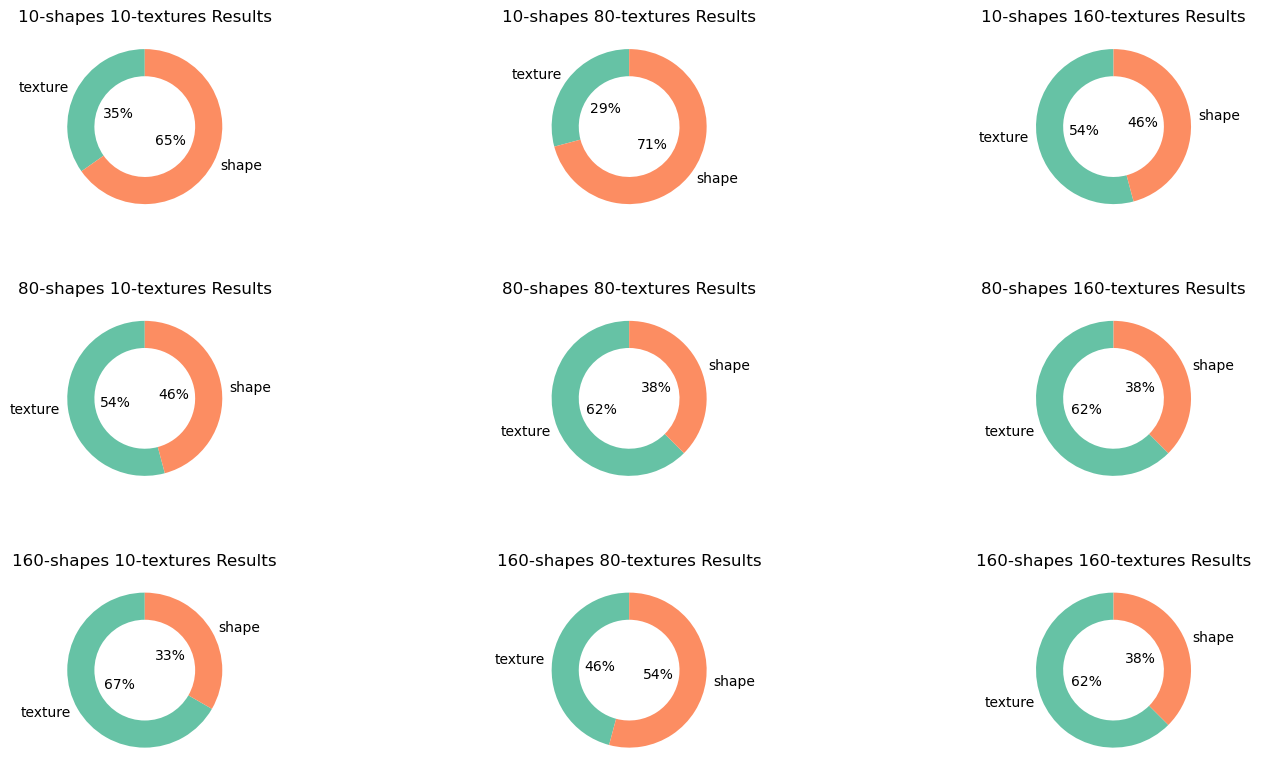

In [166]:
# create donut charts
fig, ax = plt.subplots(3, 3, figsize=(15, 10), subplot_kw={'aspect': 'equal'})

colors = ['#66c2a5', '#fc8d62']

avg_10_10 = {}
avg_10_80 = {}
avg_10_160 = {}
avg_80_10 = {}
avg_80_80 = {}
avg_80_160 = {}
avg_160_10 = {}
avg_160_80 = {}
avg_160_160 = {}

for idx, (model_name, data) in enumerate(bias_results.items()):
    values = list(data.values()) 
    labels = list(data.keys())

    if "10 10" in model_name:
        cur_avg = avg_10_10
    elif "10 80" in model_name:
        cur_avg = avg_10_80
    elif "10 160" in model_name:
        cur_avg = avg_10_160
    elif "80 10" in model_name:
        cur_avg = avg_80_10
    elif "80 80" in model_name:
        cur_avg = avg_80_80
    elif "80 160" in model_name:
        cur_avg = avg_80_160
    elif "160 10" in model_name:
        cur_avg = avg_160_10
    elif "160 80" in model_name:
        cur_avg = avg_160_80
    elif "160 160" in model_name:
        cur_avg = avg_160_160
    else:
        raise Exception(f"Didn't found model {model_name}")

    if labels[0] in cur_avg.keys():
        cur_avg["shape"] += values[0]["shape"] + values[1]["shape"] 
        cur_avg["texture"] += values[0]["texture"] + values[1]["texture"]
    else:
        cur_avg["shape"] = values[0]["shape"] + values[1]["shape"] 
        cur_avg["texture"] = values[0]["texture"] + values[1]["texture"]

complete_dict = {
    "10-shapes 10-textures": avg_10_10,
    "10-shapes 80-textures": avg_10_80,
    "10-shapes 160-textures": avg_10_160,
    "80-shapes 10-textures": avg_80_10,
    "80-shapes 80-textures": avg_80_80,
    "80-shapes 160-textures": avg_80_160,
    "160-shapes 10-textures": avg_160_10,
    "160-shapes 80-textures": avg_160_80,
    "160-shapes 160-textures": avg_160_160
}

# bake donut
cur_idx = 0
for key, value_dict in complete_dict.items(): 
    row = cur_idx // 3
    col = cur_idx % 3

    ax[row][col].pie(
        [value_dict["texture"], value_dict["shape"]],
        labels=["texture", "shape"],
        autopct='%1.0f%%',
        startangle=90,
        colors=colors,
        wedgeprops={'width': 0.35},  # change from circle to donut
        pctdistance=0.38
    )
    ax[row][col].set_title(f"{key} Results", fontsize=12)

    cur_idx += 1

# Distance between the charts
plt.subplots_adjust(wspace=1.5)
# fig.suptitle("Texture vs Shape Bias on Confusing Data", fontsize=14)
plt.show()

---
### In-Distribution Experiment

Set path to the pickle result files

In [167]:
PATH = "D:/3xM/3xM_Test_Dataset/RESULTS/In-Distribution Experiment"    # Sim-to-real Experiment, In-Distribution Experiment
os.listdir(PATH)

['known-known', 'known-unknown', 'unknown-known', 'unknown-unknown']

Loading all results

In [168]:
results = dict()
for cur_dataset in os.listdir(PATH):
    cur_dataset_path = os.path.join(PATH, cur_dataset)
    results[cur_dataset] = {}

    for cur_file in os.listdir(cur_dataset_path):
        cur_path = os.path.join(cur_dataset_path, cur_file)
        cur_name = ".".join(cur_file.split(".")[:-1])

        # get the result
        if cur_path.endswith(".pkl"):
            with open(cur_path, "rb") as file:  
                loaded_dict = pickle.load(file)
            results[cur_dataset][cur_name] = dict()
            for key, value in loaded_dict.items():
                value = [cur_value*100 if cur_value is not None else cur_value for cur_value in value]
            
                results[cur_dataset][cur_name][key] = value

In [169]:
for dataset_name, dataset_dicts in results.items():
    print(f"\n\nDataset: {dataset_name}")
    for model_name, metrics in dataset_dicts.items():
        print(f"{model_name}:\n         -> {np.mean(metrics['intersection over union'])}")



Dataset: known-known
mask_rcnn_rgbd_3xM_Dataset_10_10_epoch_040_eval:
         -> 87.61298536902086
mask_rcnn_rgbd_3xM_Dataset_10_160_epoch_040_eval:
         -> 87.2934273187656
mask_rcnn_rgbd_3xM_Dataset_10_80_epoch_040_eval:
         -> 87.79861178049532
mask_rcnn_rgbd_3xM_Dataset_160_10_epoch_040_eval:
         -> 86.1523779791234
mask_rcnn_rgbd_3xM_Dataset_160_160_epoch_040_eval:
         -> 85.31254491153041
mask_rcnn_rgbd_3xM_Dataset_160_80_epoch_040_eval:
         -> 85.28999381248109
mask_rcnn_rgbd_3xM_Dataset_80_10_epoch_040_eval:
         -> 86.31169304974286
mask_rcnn_rgbd_3xM_Dataset_80_160_epoch_040_eval:
         -> 85.91891281850921
mask_rcnn_rgbd_3xM_Dataset_80_80_epoch_040_eval:
         -> 85.77901842031433
mask_rcnn_rgb_3xM_Dataset_10_10_epoch_040_eval:
         -> 87.02014056428925
mask_rcnn_rgb_3xM_Dataset_10_160_epoch_040_eval:
         -> 87.24488836880705
mask_rcnn_rgb_3xM_Dataset_10_80_epoch_040_eval:
         -> 87.3278798480256
mask_rcnn_rgb_3xM_Dataset_16

**Compare Significants of change** 

Using wilcoxon test, becuase we have only a small number of iou values and they are not normal distributed

Let the test beginn

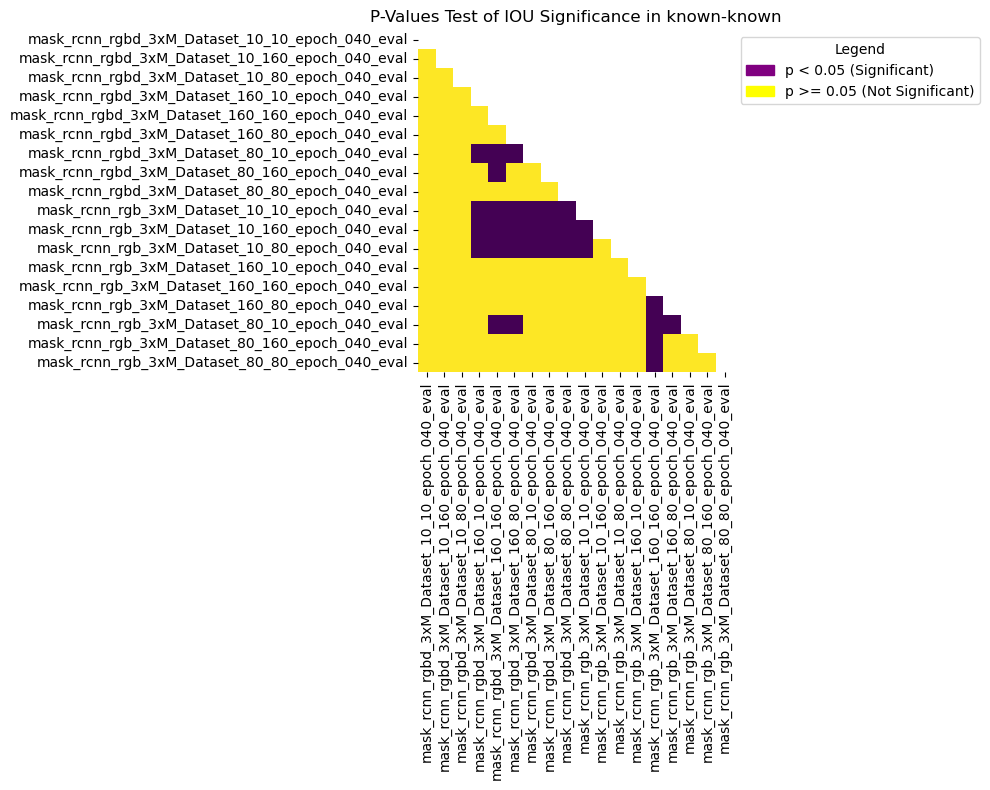

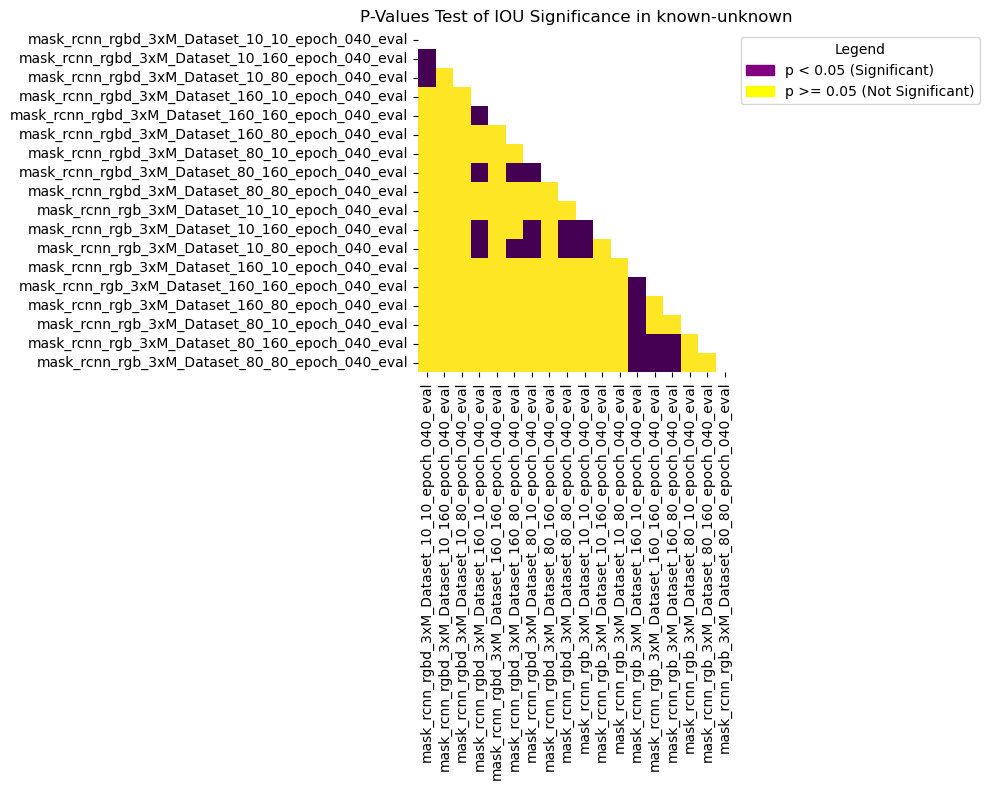

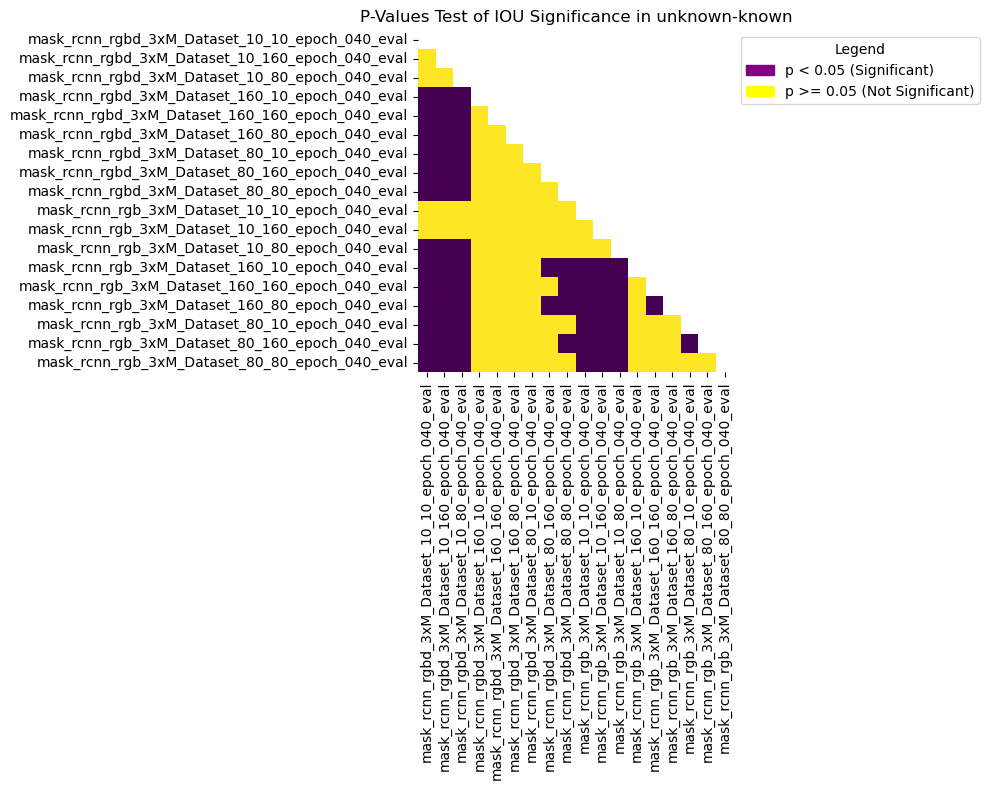

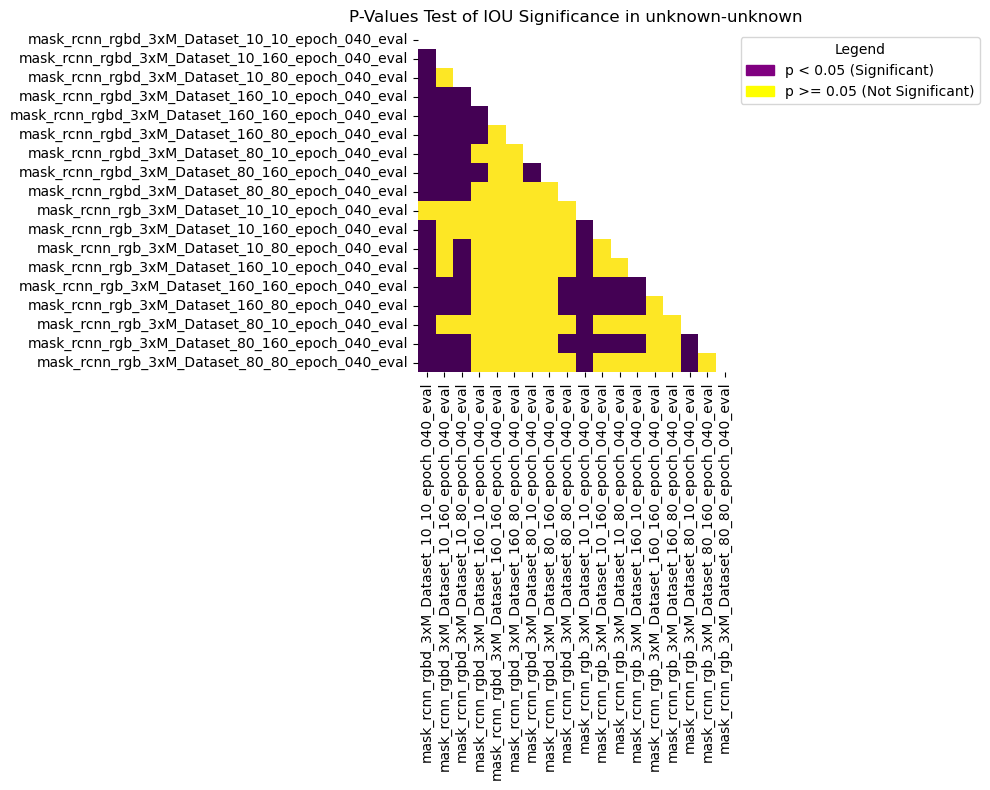

In [170]:
for dataset_name, dataset_dicts in results.items():
    keys = list(dataset_dicts.keys())
    num_results = len(keys)
    p_values_matrix = np.ones((num_results, num_results))  # Initialize with 1

    # Pairwise Wilcoxon test
    for i in range(num_results):
        for j in range(num_results):
            iou_1 = dataset_dicts[keys[i]]["intersection over union"]
            iou_2 = dataset_dicts[keys[j]]["intersection over union"]
            
            if np.mean(iou_1) - np.mean(iou_2) <= 0.01:
                p_value = 1.0
            else:
                # Statistical test
                _, p_value = stats.wilcoxon(iou_1, iou_2)

            p_values_matrix[i, j] = 1.0 if p_value >= 0.05 else 0.0

    # Plotting p-values matrix
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(p_values_matrix, dtype=bool))  # Upper triangular mask
    ax = sns.heatmap(
        p_values_matrix,
        mask=mask,
        annot=False,  # Disable annotations
        fmt=".3f",
        cmap="viridis",
        xticklabels=keys,
        yticklabels=keys,
        cbar=False  # Disable color bar
    )

    # Add a custom legend
    legend_handles = [
        mpatches.Patch(color="purple", label="p < 0.05 (Significant)"),
        mpatches.Patch(color="yellow", label="p >= 0.05 (Not Significant)")
    ]
    plt.legend(
        handles=legend_handles,
        loc="upper left",
        bbox_to_anchor=(1, 1),
        title="Legend"
    )

    plt.title(f"P-Values Test of IOU Significance in {dataset_name}")
    plt.tight_layout()
    plt.show()

**Visualize Results**

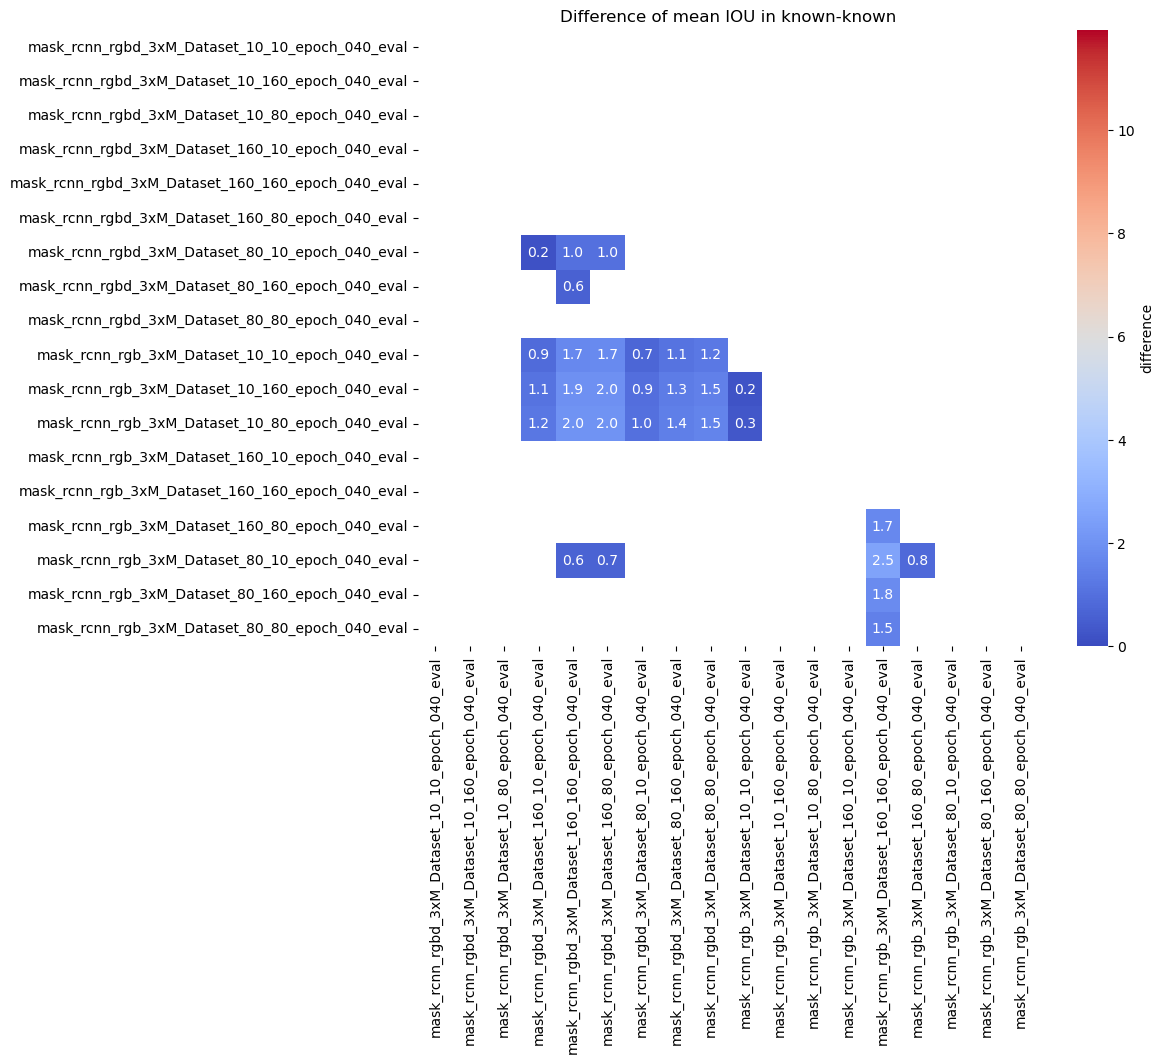

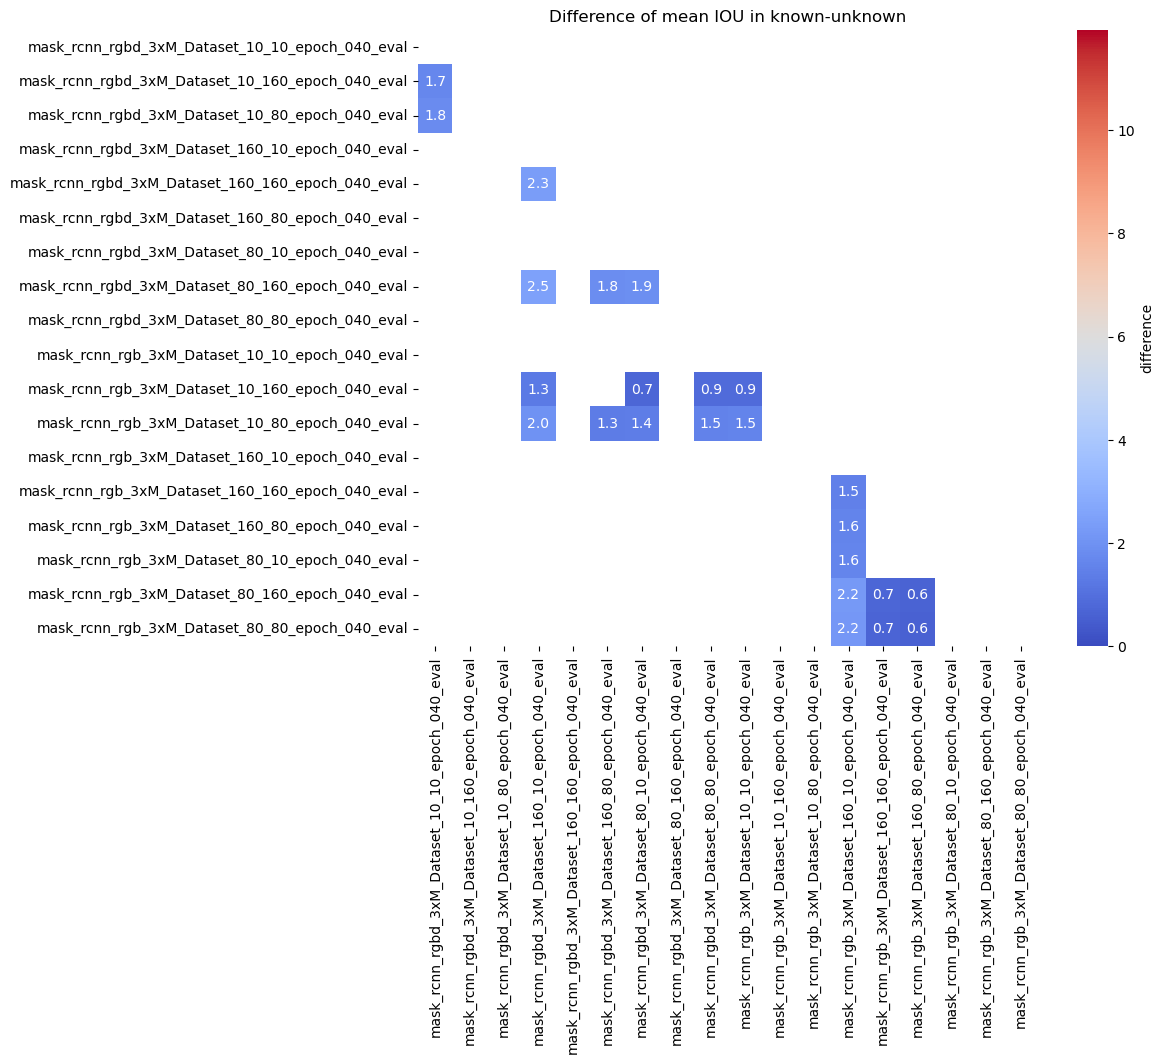

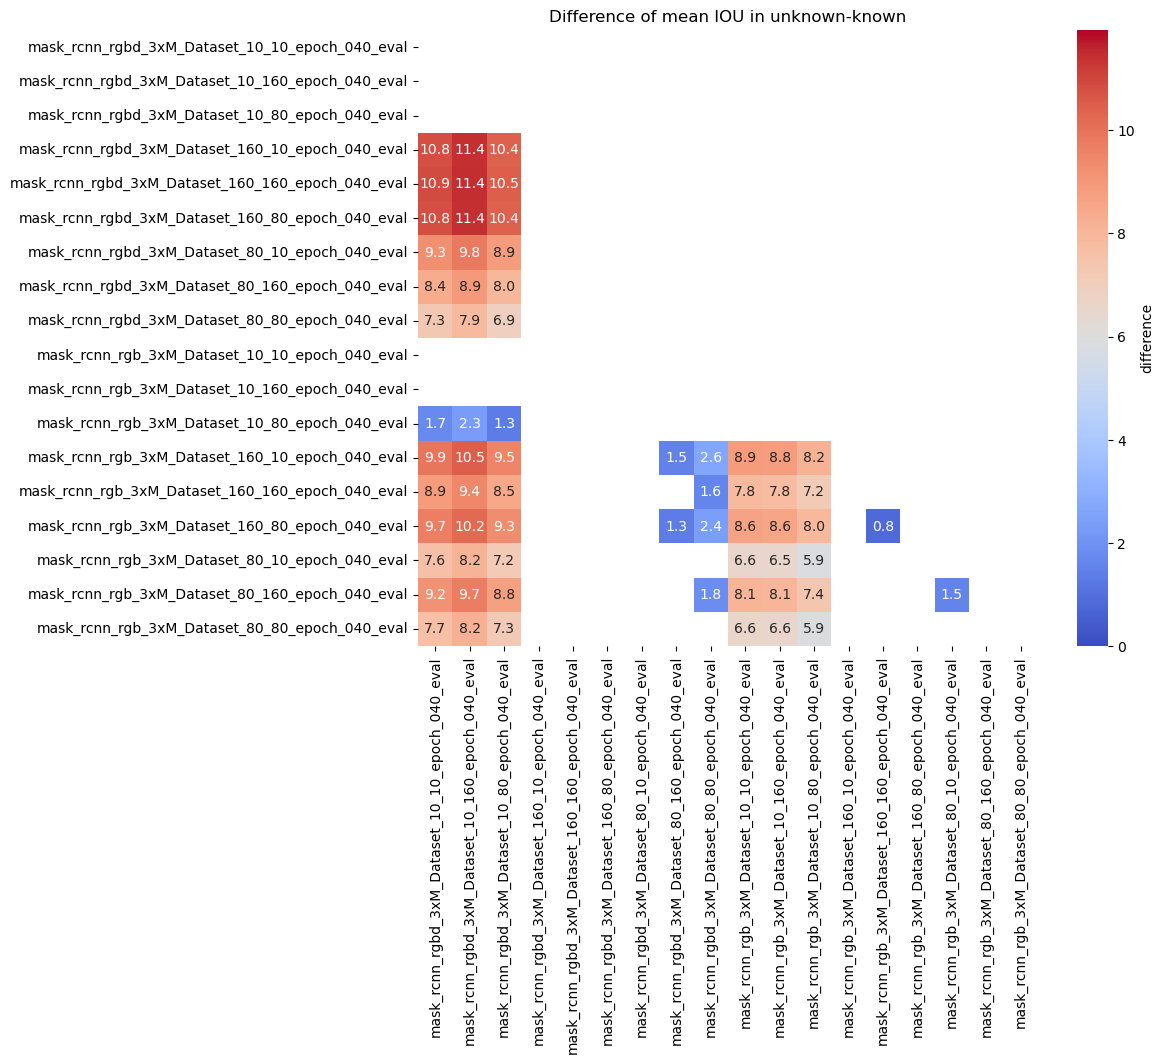

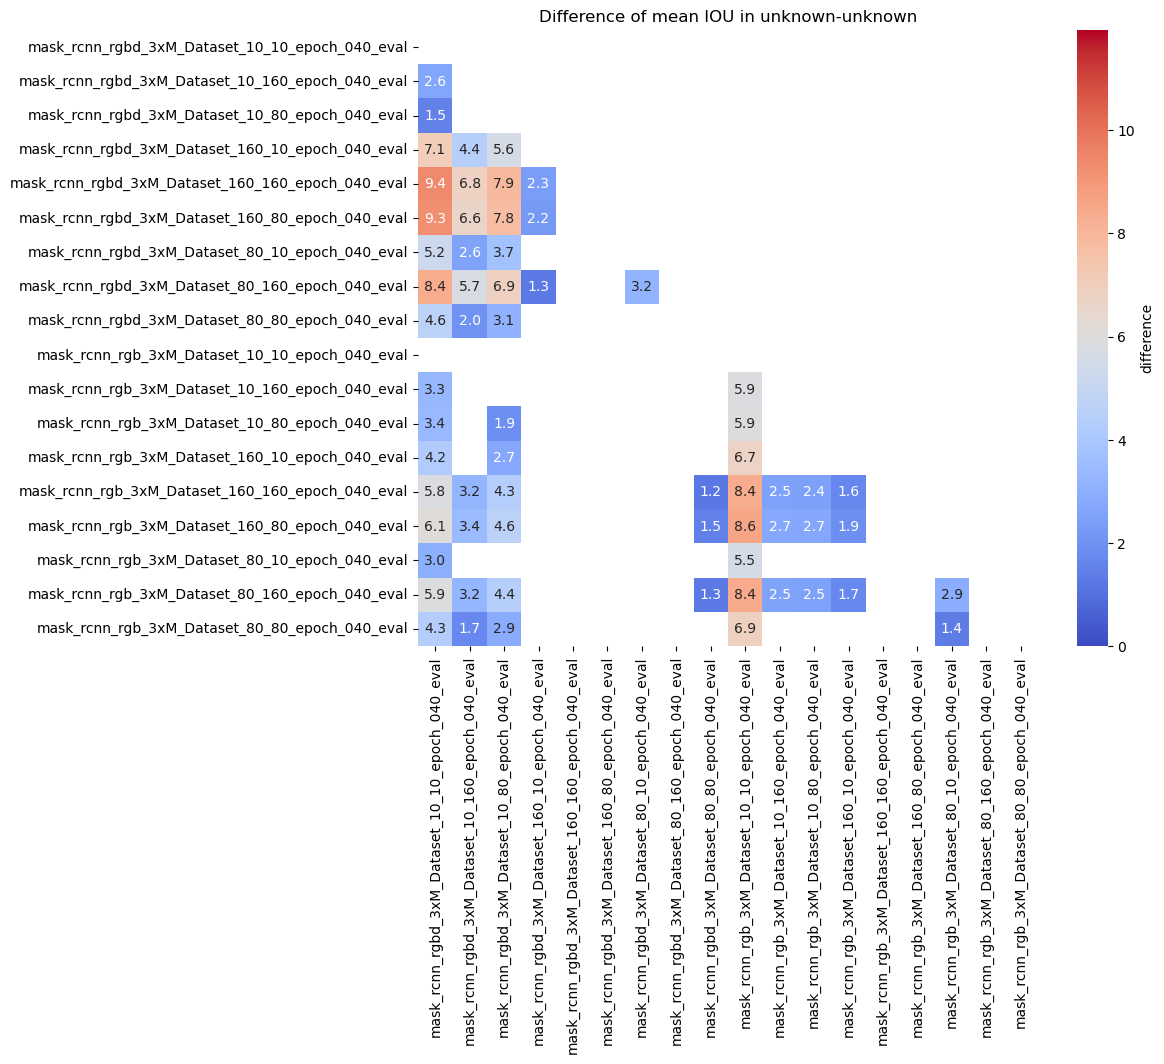

In [171]:
# calc max and min difference
global_max = None
global_min = None
for dataset_name, dataset_dicts in results.items():
    keys = list(dataset_dicts.keys())
    num_results = len(keys)
    for i in range(num_results):
        for j in range(num_results):
            iou_1 = dataset_dicts[keys[i]]["intersection over union"]
            iou_2 = dataset_dicts[keys[j]]["intersection over union"]

            difference = np.mean(iou_1) - np.mean(iou_2)

            if not global_max:
                global_max = difference
            else:
                global_max = max(global_max, difference)

            if not global_min:
                global_min = difference
            else:
                global_min = min(global_min, difference)
            
global_min = 0

for dataset_name, dataset_dicts in results.items():
    keys = list(dataset_dicts.keys())
    num_results = len(keys)
    difference_matrix = np.full((num_results, num_results), 999, dtype=float)  # init with 999
    p_values_matrix = np.ones((num_results, num_results))
    for i in range(num_results):
        for j in range(num_results):
            iou_1 = dataset_dicts[keys[i]]["intersection over union"]
            iou_2 = dataset_dicts[keys[j]]["intersection over union"]

            if np.mean(iou_1) - np.mean(iou_2) <= 0.01:
                p_value = 1.0
            else:
                # Statistical test
                _, p_value = stats.wilcoxon(iou_1, iou_2)

            p_values_matrix[i, j] = p_value

            difference_matrix[i, j] = np.mean(iou_1) - np.mean(iou_2)
            # print(difference_matrix[i, j])

    # plotting of p values of all pairs
    plt.figure(figsize=(10, 8))

    # update mask, only take when the signification is high enough
    mask = np.triu(difference_matrix) 
    new_mask = np.copy(mask)
    for i in range(num_results):
        for j in range(num_results):
            if mask[i, j] != 0.0:
                pass
            else:
                if p_values_matrix[i, j] < 0.05:
                    new_mask[i, j] = 0.0
                else:
                    new_mask[i, j] = 1.0

    sns.heatmap(difference_matrix, annot=True, mask=new_mask, fmt=".1f", cmap="coolwarm", 
                xticklabels=keys, yticklabels=keys, cbar_kws={"label": "difference"},
                vmin=global_min, vmax=global_max)
                # mask=mask,

    plt.title(f"Difference of mean IOU in {dataset_name}")
    plt.show()

C:\Users\tobia\AppData\Local\Temp\ipykernel_18160\2163579135.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_results.keys(), rotation=45, ha="right")


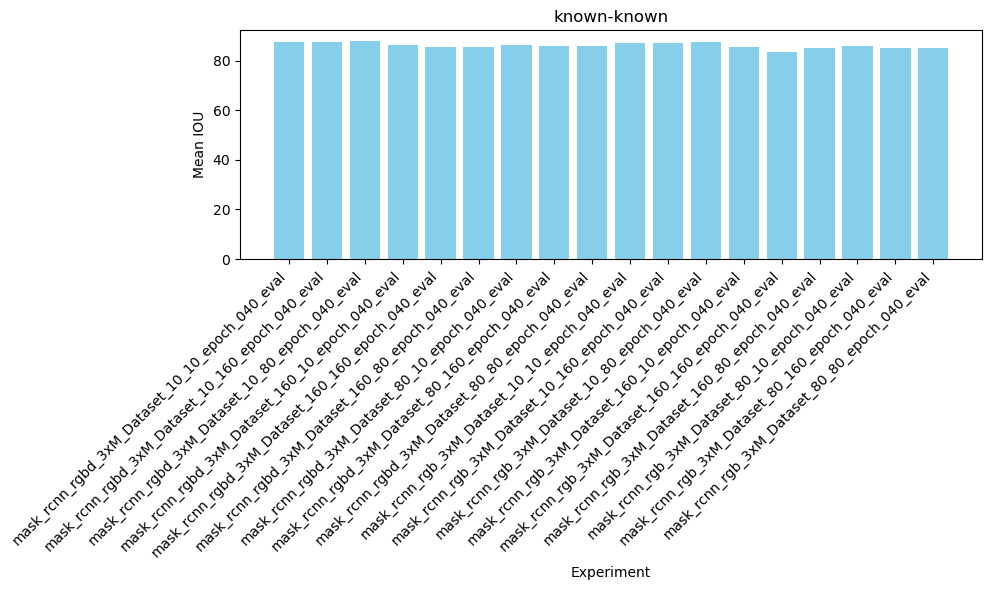

C:\Users\tobia\AppData\Local\Temp\ipykernel_18160\2163579135.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_results.keys(), rotation=45, ha="right")


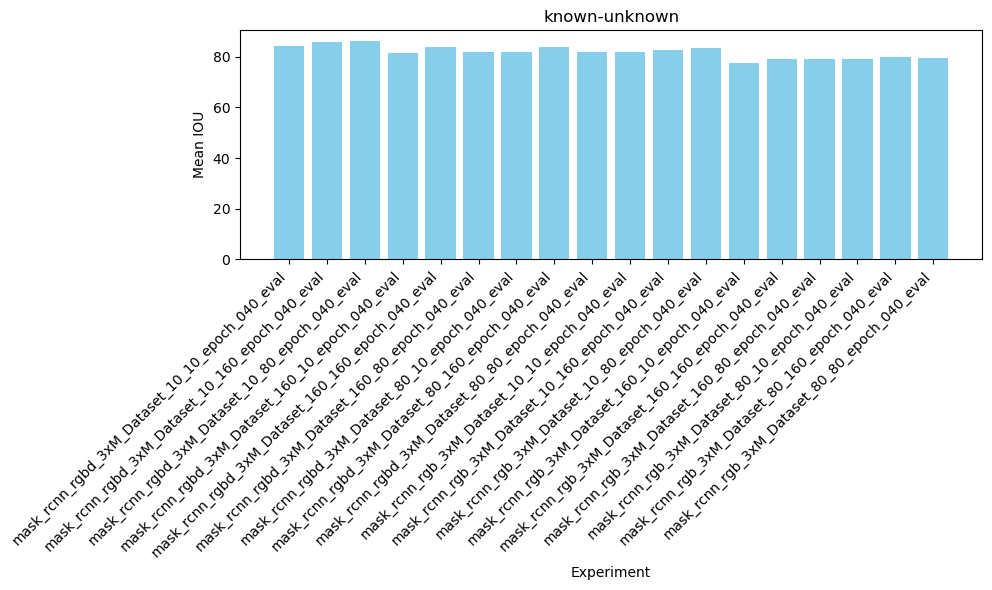

C:\Users\tobia\AppData\Local\Temp\ipykernel_18160\2163579135.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_results.keys(), rotation=45, ha="right")


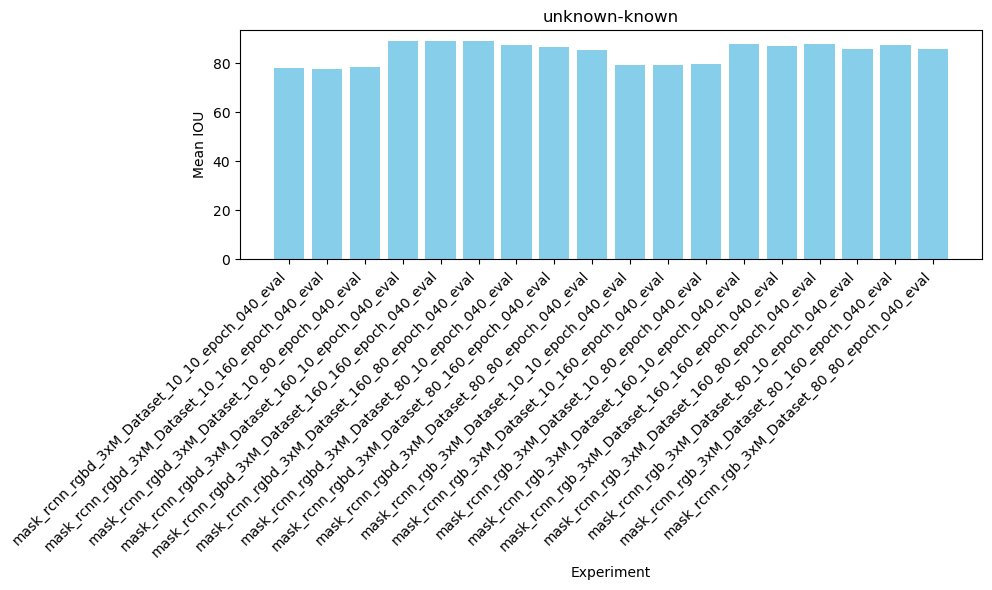

C:\Users\tobia\AppData\Local\Temp\ipykernel_18160\2163579135.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_results.keys(), rotation=45, ha="right")


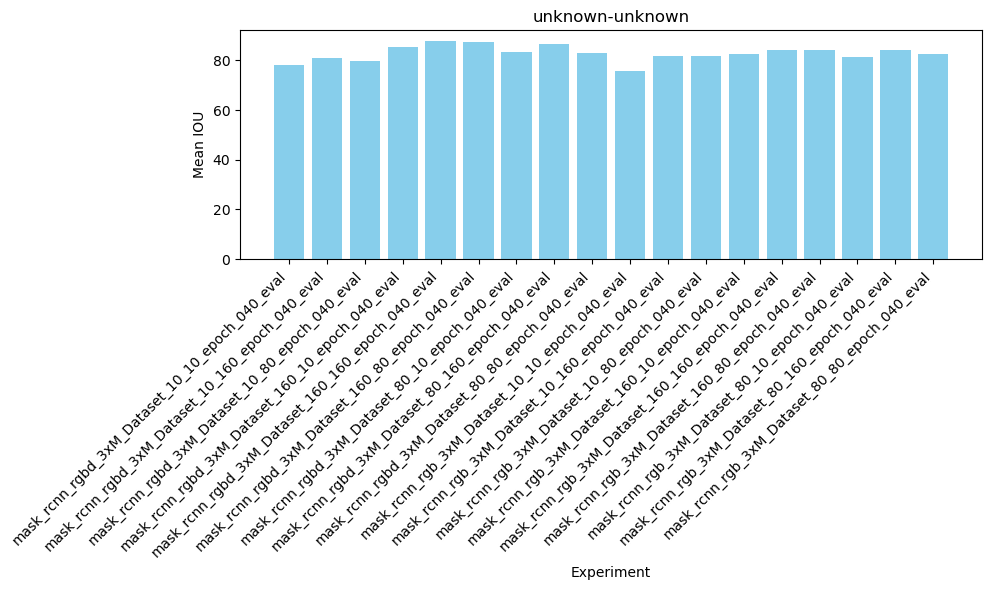

In [172]:
for dataset_name, dataset_dicts in results.items():
    # Calculate mean IOU for each experiment
    mean_results = {name: np.mean(data["intersection over union"]) for name, data in dataset_dicts.items()}

    # Plot the mean results in a bar chart using subplots
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(mean_results.keys(), mean_results.values(), color="skyblue")
    ax.set_xlabel("Experiment")
    ax.set_ylabel("Mean IOU")
    ax.set_title("Mean IOU Results by Experiment")
    ax.set_xticklabels(mean_results.keys(), rotation=45, ha="right")

    # Show the plot
    plt.title(f"{dataset_name}")
    plt.tight_layout()
    plt.show()

---
### Sim-to-Real Experiment

Set path to the pickle result files

In [173]:
PATH = "D:/3xM/3xM_Test_Dataset/RESULTS/Sim-to-real Experiment"    # Sim-to-real Experiment, In-Distribution Experiment
os.listdir(PATH)

['mask_rcnn_rgbd_3xM_Dataset_10_10_epoch_040_eval.pkl',
 'mask_rcnn_rgbd_3xM_Dataset_10_160_epoch_040_eval.pkl',
 'mask_rcnn_rgbd_3xM_Dataset_10_80_epoch_040_eval.pkl',
 'mask_rcnn_rgbd_3xM_Dataset_160_10_epoch_040_eval.pkl',
 'mask_rcnn_rgbd_3xM_Dataset_160_160_epoch_040_eval.pkl',
 'mask_rcnn_rgbd_3xM_Dataset_160_80_epoch_040_eval.pkl',
 'mask_rcnn_rgbd_3xM_Dataset_80_10_epoch_040_eval.pkl',
 'mask_rcnn_rgbd_3xM_Dataset_80_160_epoch_040_eval.pkl',
 'mask_rcnn_rgbd_3xM_Dataset_80_80_epoch_040_eval.pkl',
 'mask_rcnn_rgb_3xM_Dataset_10_10_epoch_040_eval.pkl',
 'mask_rcnn_rgb_3xM_Dataset_10_160_epoch_040_eval.pkl',
 'mask_rcnn_rgb_3xM_Dataset_10_80_epoch_040_eval.pkl',
 'mask_rcnn_rgb_3xM_Dataset_160_10_epoch_040_eval.pkl',
 'mask_rcnn_rgb_3xM_Dataset_160_160_epoch_040_eval.pkl',
 'mask_rcnn_rgb_3xM_Dataset_160_80_epoch_040_eval.pkl',
 'mask_rcnn_rgb_3xM_Dataset_80_10_epoch_040_eval.pkl',
 'mask_rcnn_rgb_3xM_Dataset_80_160_epoch_040_eval.pkl',
 'mask_rcnn_rgb_3xM_Dataset_80_80_epoch_040_

Loading all results

In [174]:
results = dict()

for cur_file in os.listdir(PATH):
    cur_path = os.path.join(PATH, cur_file)
    cur_name = ".".join(cur_file.split(".")[:-1])

    # get the result
    if cur_path.endswith(".pkl"):
        with open(cur_path, "rb") as file:  
            loaded_dict = pickle.load(file)
        results[cur_name] = dict()
        for key, value in loaded_dict.items():
            value = [cur_value*100 if cur_value is not None else cur_value for cur_value in value]
        
            results[cur_name][key] = value

In [175]:
for model_name, metrics in results.items():
    print(f"{model_name}:\n         -> {np.mean(metrics['intersection over union'])}")

mask_rcnn_rgbd_3xM_Dataset_10_10_epoch_040_eval:
         -> 43.78741551618967
mask_rcnn_rgbd_3xM_Dataset_10_160_epoch_040_eval:
         -> 52.042893385720696
mask_rcnn_rgbd_3xM_Dataset_10_80_epoch_040_eval:
         -> 51.97460001311692
mask_rcnn_rgbd_3xM_Dataset_160_10_epoch_040_eval:
         -> 46.790795211985504
mask_rcnn_rgbd_3xM_Dataset_160_160_epoch_040_eval:
         -> 55.17058105115237
mask_rcnn_rgbd_3xM_Dataset_160_80_epoch_040_eval:
         -> 50.03849807794983
mask_rcnn_rgbd_3xM_Dataset_80_10_epoch_040_eval:
         -> 41.00488050663801
mask_rcnn_rgbd_3xM_Dataset_80_160_epoch_040_eval:
         -> 55.606610302952575
mask_rcnn_rgbd_3xM_Dataset_80_80_epoch_040_eval:
         -> 49.59135221664684
mask_rcnn_rgb_3xM_Dataset_10_10_epoch_040_eval:
         -> 18.299866669232365
mask_rcnn_rgb_3xM_Dataset_10_160_epoch_040_eval:
         -> 37.32203703193336
mask_rcnn_rgb_3xM_Dataset_10_80_epoch_040_eval:
         -> 21.925478612846742
mask_rcnn_rgb_3xM_Dataset_160_10_epoch_040_

**Compare Significants of change** 

Using wilcoxon test, becuase we have only a small number of iou values and they are not normal distributed

Let the test beginn

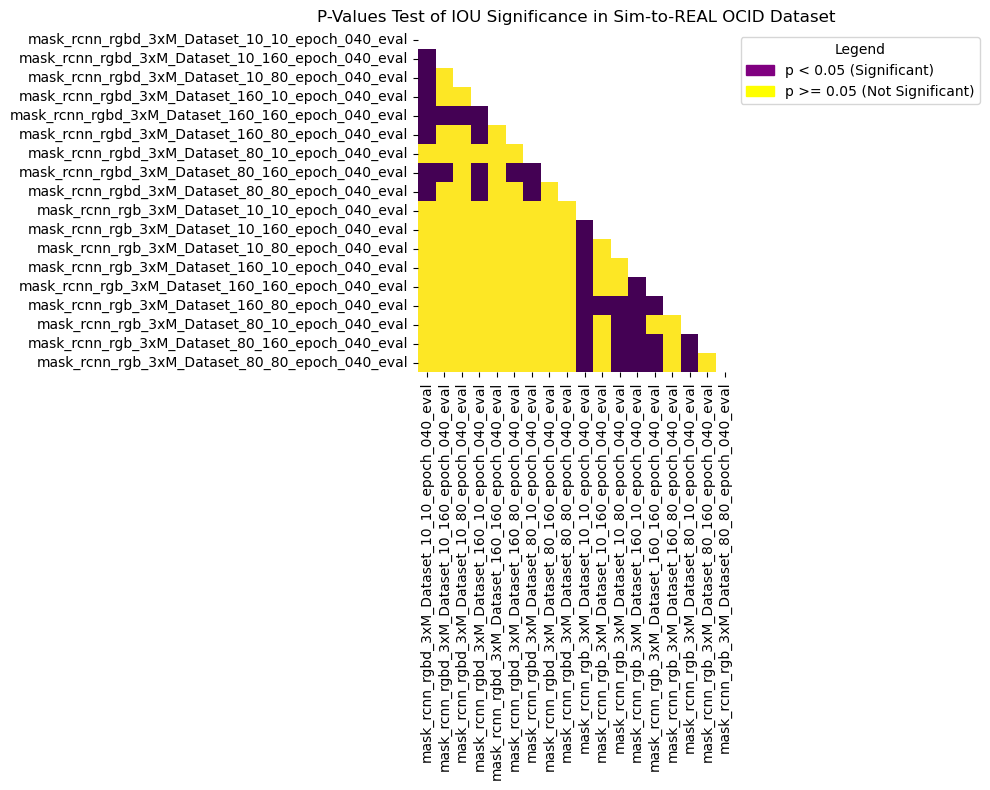

In [176]:
keys = list(results.keys())
num_results = len(keys)
p_values_matrix = np.ones((num_results, num_results))  # Initialize with 1

# Pairwise Wilcoxon test
for i in range(num_results):
    for j in range(num_results):
        iou_1 = results[keys[i]]["intersection over union"]
        iou_2 = results[keys[j]]["intersection over union"]
        
        if np.mean(iou_1) - np.mean(iou_2) <= 0.01:
            p_value = 1.0
        else:
            # Statistical test
            _, p_value = stats.wilcoxon(iou_1, iou_2)

        p_values_matrix[i, j] = 1.0 if p_value >= 0.05 else 0.0

# Plotting p-values matrix
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(p_values_matrix, dtype=bool))  # Upper triangular mask
ax = sns.heatmap(
    p_values_matrix,
    mask=mask,
    annot=False,  # Disable annotations
    fmt=".3f",
    cmap="viridis",
    xticklabels=keys,
    yticklabels=keys,
    cbar=False  # Disable color bar
)

# Add a custom legend
legend_handles = [
    mpatches.Patch(color="purple", label="p < 0.05 (Significant)"),
    mpatches.Patch(color="yellow", label="p >= 0.05 (Not Significant)")
]
plt.legend(
    handles=legend_handles,
    loc="upper left",
    bbox_to_anchor=(1, 1),
    title="Legend"
)

plt.title(f"P-Values Test of IOU Significance in Sim-to-REAL OCID Dataset")
plt.tight_layout()
plt.show()

**Visualize Results**

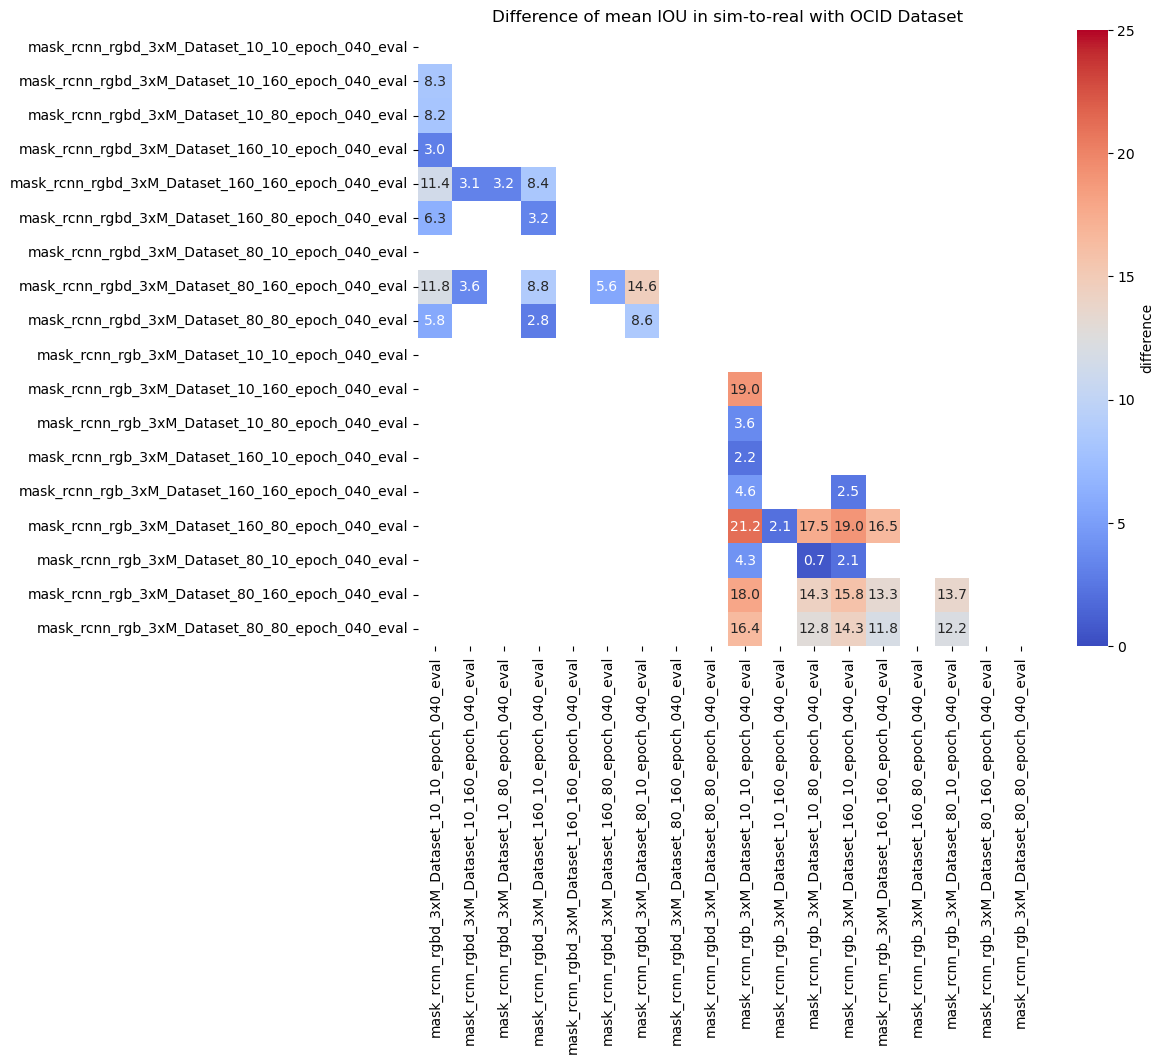

In [180]:
# calc max and min difference
global_max = None
global_min = None
keys = list(results.keys())
num_results = len(keys)
for i in range(num_results):
    for j in range(num_results):
        iou_1 = results[keys[i]]["intersection over union"]
        iou_2 = results[keys[j]]["intersection over union"]

        difference = np.mean(iou_1) - np.mean(iou_2)

        if not global_max:
            global_max = difference
        else:
            global_max = max(global_max, difference)

        if not global_min:
            global_min = difference
        else:
            global_min = min(global_min, difference)

global_max = 25
global_min = 0      

keys = list(results.keys())
num_results = len(keys)
difference_matrix = np.full((num_results, num_results), 999, dtype=float)  # init with 999
p_values_matrix = np.ones((num_results, num_results))
for i in range(num_results):
    for j in range(num_results):
        iou_1 = results[keys[i]]["intersection over union"]
        iou_2 = results[keys[j]]["intersection over union"]

        if np.mean(iou_1) - np.mean(iou_2) <= 0.01:
            p_value = 1.0
        else:
            # Statistical test
            _, p_value = stats.wilcoxon(iou_1, iou_2)

        p_values_matrix[i, j] = p_value

        difference_matrix[i, j] = np.mean(iou_1) - np.mean(iou_2)
        # print(difference_matrix[i, j])

# plotting of p values of all pairs
plt.figure(figsize=(10, 8))

# update mask, only take when the signification is high enough
mask = np.triu(difference_matrix) 
new_mask = np.copy(mask)
for i in range(num_results):
    for j in range(num_results):
        if mask[i, j] != 0.0:
            pass
        else:
            if p_values_matrix[i, j] < 0.05:
                new_mask[i, j] = 0.0
            else:
                new_mask[i, j] = 1.0

sns.heatmap(difference_matrix, annot=True, mask=new_mask, fmt=".1f", cmap="coolwarm", 
            xticklabels=keys, yticklabels=keys, cbar_kws={"label": "difference"},
            vmin=global_min, vmax=global_max)
            # mask=mask,

plt.title(f"Difference of mean IOU in sim-to-real with OCID Dataset")
plt.show()

C:\Users\tobia\AppData\Local\Temp\ipykernel_18160\3924997166.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_results.keys(), rotation=45, ha="right")


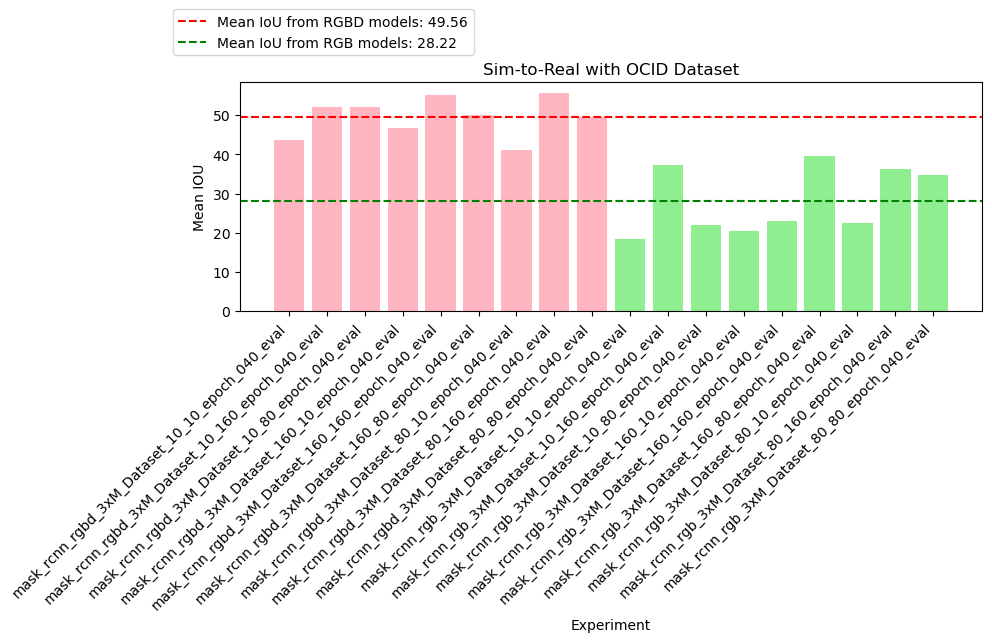

In [221]:
# Calculate mean IOU for each experiment
mean_results = {name: np.mean(data["intersection over union"]) for name, data in results.items()}

colors = ["#FFB6C1" if "rgbd" in key else "#90EE90" for key in mean_results.keys()]

# Plot the mean results in a bar chart using subplots
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(mean_results.keys(), mean_results.values(), color=colors)
ax.set_xlabel("Experiment")
ax.set_ylabel("Mean IOU")
ax.set_title("Mean IOU Results by Experiment")
ax.set_xticklabels(mean_results.keys(), rotation=45, ha="right")

# add plot line from mean
mean_rgbd = []
mean_rgb = []
for key, value in mean_results.items():
    if "rgbd" in key:
        mean_rgbd += [value]
    else:
        mean_rgb += [value]
ax.axhline(y=np.mean(mean_rgbd), color="red", linestyle="--", label=f"Mean IoU from RGBD models: {np.mean(mean_rgbd):.2f}")
ax.axhline(y=np.mean(mean_rgb), color="green", linestyle="--", label=f"Mean IoU from RGB models: {np.mean(mean_rgb):.2f}")

# Show the plot
plt.title(f"Sim-to-Real with OCID Dataset")
plt.tight_layout()
plt.legend(loc="upper left", bbox_to_anchor=(-0.1, 1.35))
plt.show()

In [195]:
mean_results.keys()

dict_keys(['mask_rcnn_rgbd_3xM_Dataset_10_10_epoch_040_eval', 'mask_rcnn_rgbd_3xM_Dataset_10_160_epoch_040_eval', 'mask_rcnn_rgbd_3xM_Dataset_10_80_epoch_040_eval', 'mask_rcnn_rgbd_3xM_Dataset_160_10_epoch_040_eval', 'mask_rcnn_rgbd_3xM_Dataset_160_160_epoch_040_eval', 'mask_rcnn_rgbd_3xM_Dataset_160_80_epoch_040_eval', 'mask_rcnn_rgbd_3xM_Dataset_80_10_epoch_040_eval', 'mask_rcnn_rgbd_3xM_Dataset_80_160_epoch_040_eval', 'mask_rcnn_rgbd_3xM_Dataset_80_80_epoch_040_eval', 'mask_rcnn_rgb_3xM_Dataset_10_10_epoch_040_eval', 'mask_rcnn_rgb_3xM_Dataset_10_160_epoch_040_eval', 'mask_rcnn_rgb_3xM_Dataset_10_80_epoch_040_eval', 'mask_rcnn_rgb_3xM_Dataset_160_10_epoch_040_eval', 'mask_rcnn_rgb_3xM_Dataset_160_160_epoch_040_eval', 'mask_rcnn_rgb_3xM_Dataset_160_80_epoch_040_eval', 'mask_rcnn_rgb_3xM_Dataset_80_10_epoch_040_eval', 'mask_rcnn_rgb_3xM_Dataset_80_160_epoch_040_eval', 'mask_rcnn_rgb_3xM_Dataset_80_80_epoch_040_eval'])

C:\Users\tobia\AppData\Local\Temp\ipykernel_18160\154576972.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(keys, rotation=45, ha="right")


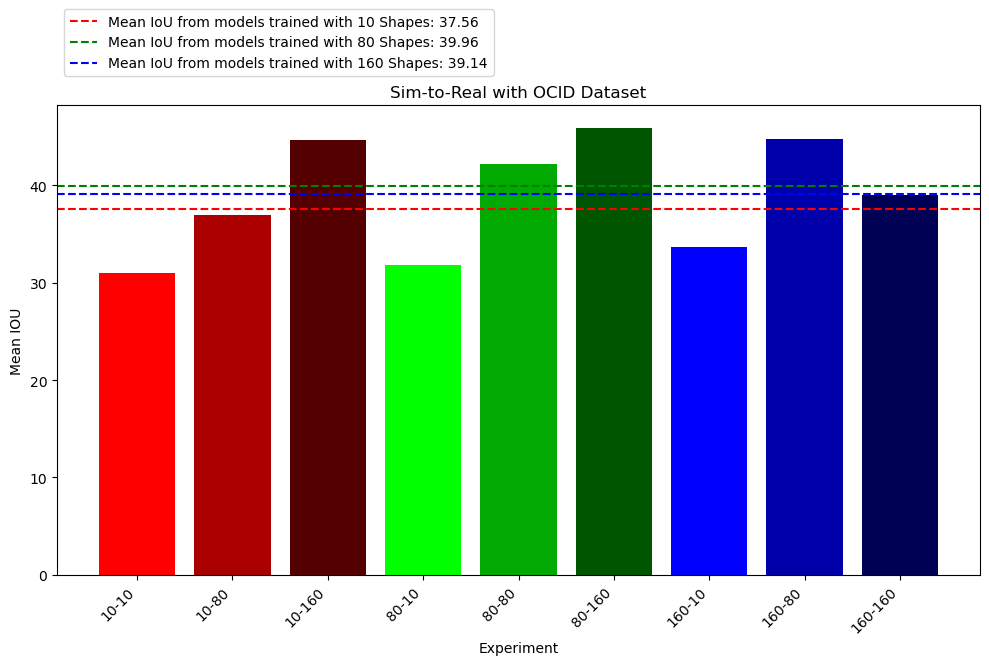

In [217]:
# Calculate mean IOU for each experiment
mean_results = {}
colors = []
color_assign = {}
color_counter = 0
for name, data in results.items():
    data = np.mean(data["intersection over union"])
    name = "-".join(name.split("_")[5:7])
    if name in mean_results.keys():
        mean_results[name] = np.mean([mean_results[name], data])
        colors += [color_assign[name]]
    else:
        mean_results[name] = data
    
        if color_counter == 0:
            new_color = "#FF0000"
        elif color_counter == 1:
            new_color = "#AA0000"
        elif color_counter == 2:
            new_color = "#550000"
        elif color_counter == 3:
            new_color = "#00FF00"
        elif color_counter == 4:
            new_color = "#00AA00"
        elif color_counter == 5:
            new_color = "#005500"
        elif color_counter == 6:
            new_color = "#0000FF"
        elif color_counter == 7:
            new_color = "#0000AA"
        elif color_counter == 8:
            new_color = "#000055"
        else:
            raise Exception("Color counter too high")

        colors += [new_color]
        color_assign[name] = new_color
        color_counter += 1

# adjust order
keys = list(mean_results.keys())
values = list(mean_results.values())

keys[1], keys[2] = keys[2], keys[1]
values[1], values[2] = values[2], values[1]

keys[4], keys[5] = keys[5], keys[4]
values[4], values[5] = values[5], values[4]

keys[7], keys[8] = keys[8], keys[7]
values[7], values[8] = values[8], values[7]

keys[3], keys[4], keys[5], keys[6], keys[7], keys[8] = keys[6], keys[7], keys[8], keys[3], keys[4], keys[5] 
values[3], values[4], values[5], values[6], values[7], values[8] = values[6], values[7], values[8], values[3], values[4], values[5]

# Plot the mean results in a bar chart using subplots
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(keys, values, color=colors)
ax.set_xlabel("Experiment")
ax.set_ylabel("Mean IOU")
ax.set_title("Mean IOU Results by Experiment")
ax.set_xticklabels(keys, rotation=45, ha="right")

# add plot line from mean
mean_10 = []
mean_80 = []
mean_160 = []
for key, value in mean_results.items():
    if key.startswith("10"):
        mean_10 += [value]
    elif key.startswith("80"):
        mean_80 += [value]
    else:
        mean_160 += [value]
ax.axhline(y=np.mean(mean_10), color="red", linestyle="--", label=f"Mean IoU from models trained with 10 Shapes: {np.mean(mean_10):.2f}")
ax.axhline(y=np.mean(mean_80), color="green", linestyle="--", label=f"Mean IoU from models trained with 80 Shapes: {np.mean(mean_80):.2f}")
ax.axhline(y=np.mean(mean_160), color="blue", linestyle="--", label=f"Mean IoU from models trained with 160 Shapes: {np.mean(mean_160):.2f}")

# mean_10 = []
# mean_80 = []
# mean_160 = []
# for key, value in mean_results.items():
#     if key.endswith("10"):
#         mean_10 += [value]
#     elif key.endswith("80"):
#         mean_80 += [value]
#     else:
#         mean_160 += [value]
# ax.axhline(y=np.mean(mean_10), color="#700000", linestyle="--", label=f"Mean from models trained with 10 Textures: {np.mean(mean_10):.2f}")
# ax.axhline(y=np.mean(mean_80), color="#007000", linestyle="--", label=f"Mean from models trained with 80 Textures: {np.mean(mean_80):.2f}")
# ax.axhline(y=np.mean(mean_160), color="#000070", linestyle="--", label=f"Mean from models trained with 160 Textures: {np.mean(mean_160):.2f}")

# Show the plot
plt.title(f"Sim-to-Real with OCID Dataset")
plt.tight_layout()
plt.legend(loc="upper left", bbox_to_anchor=(-0.0, 1.22))
plt.show()

In [216]:
mean_10 = []
mean_80 = []
mean_160 = []
for key, value in mean_results.items():
    if key.endswith("10"):
        mean_10 += [value]
    elif key.endswith("80"):
        mean_80 += [value]
    else:
        mean_160 += [value]

print(f"Mean IoU from models trained with 10 Textures: {np.mean(mean_10):.2f}%")
print(f"Mean IoU from models trained with 80 Textures: {np.mean(mean_80):.2f}%")
print(f"Mean IoU from models trained with 160 Textures: {np.mean(mean_160):.2f}%")

Mean IoU from models trained with 10 Textures: 32.15%
Mean IoU from models trained with 80 Textures: 41.29%
Mean IoU from models trained with 160 Textures: 43.22%


---

... more visualizations

---